In [1]:
!pip install -q efficientnet_pytorch

In [2]:
import cv2
import os, os.path
from PIL import Image
import gc
import time
import datetime

import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm 

from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import sklearn

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
import albumentations as A
from albumentations.pytorch.transforms import ToTensor
from efficientnet_pytorch import EfficientNet
import warnings
warnings.filterwarnings("ignore")

In [3]:
warnings.simplefilter('ignore')
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(47)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Data Loading**
**Using malanoma merged external dataset** 

In [5]:
images_dir = "../input/melanoma-external-malignant-256/"
train_df = pd.read_csv("../input/external-clean/train_final.csv")
test_df = pd.read_csv("../input/external-clean/test_final.csv")

Samples with Melanoma


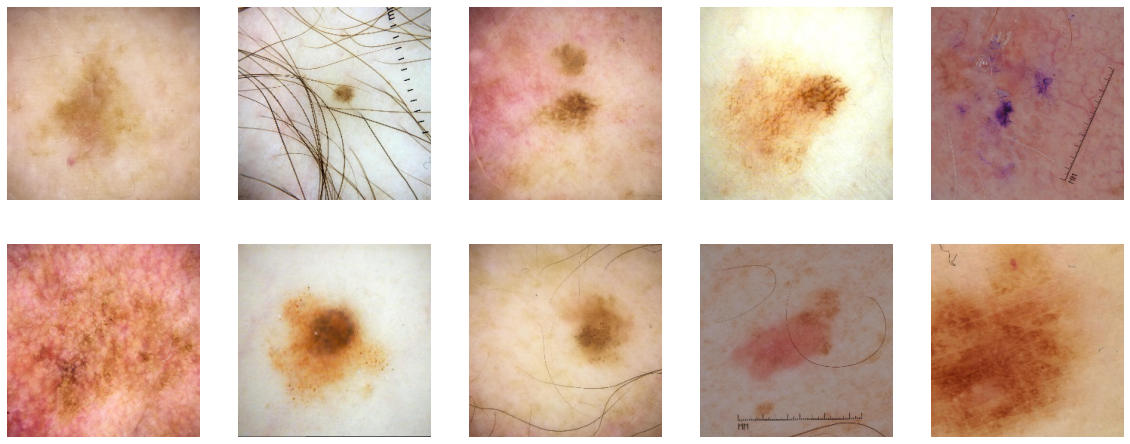

In [6]:
print("Samples with Melanoma")
imgs = train_df[train_df.target==1]['path_jpg'].values
_, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()
for f_name,ax in zip(imgs[300:310],axs):
    img = Image.open(f_name)
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [7]:
class MelanomaDataset(Dataset):
    def __init__(self, df,is_train=True, transforms=None):
        self.df = df
        self.transforms = transforms
        self.is_train = is_train
    
    def __getitem__(self, index):
        im_path =  self.df.iloc[index]["path_jpg"]
        image = Image.open(im_path)
        
        if self.transforms:
            image = self.transforms(**{"image": np.array(image)})["image"]
        if self.is_train:
            target = self.df.iloc[index]["target"]
            target = torch.tensor([target],dtype=torch.float32)
            return (image,target)
        else:
            return image
        
    def __len__(self):
        return len(self.df)

In [8]:
def get_augmentations(p=0.5):
    imagenet_stats = {'mean':[0.485, 0.456, 0.406], 'std':[0.229, 0.224, 0.225]}
    train_tfms = A.Compose([
        A.Cutout(p=p),
        A.RandomRotate90(p=p),
        A.Flip(p=p),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2,
                                       contrast_limit=0.2,
                                       ),
            A.HueSaturationValue(
                hue_shift_limit=20,
                sat_shift_limit=50,
                val_shift_limit=50)
        ], p=p),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=p),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=p),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=p),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=0.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=p), 
        ToTensor(normalize=imagenet_stats)
        ])
    
    test_tfms = A.Compose([
        ToTensor(normalize=imagenet_stats)
        ])
    return train_tfms, test_tfms
train_tfms,test_tfms = get_augmentations()

# Neural Network : EfficientNet

In [9]:
class EffNet(nn.Module):
    def __init__(self,model_name='efficientnet-b4'):
        super().__init__()
        
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.backbone = EfficientNet.from_pretrained("efficientnet-b4")
        in_features = getattr(self.backbone,'_fc').in_features
        self.classifier = nn.Sequential(nn.Linear(in_features,1024),
                                        nn.ReLU(),
                                        nn.Dropout(p=0.5),
                                        nn.Linear(1024,512),
                                        nn.ReLU(),
                                        nn.Dropout(p=0.5), 
                                        nn.Linear(512,1)
                                       )
        
    def forward(self,x):
        x = self.backbone.extract_features(x)
        x = self.pool(x)
        return self.classifier(x.view(x.shape[0],-1))

**Example model and loss calculation**

In [10]:
example_dataset = MelanomaDataset(df = train_df,
                                  is_train=True,
                                  transforms=train_tfms)
example_loader = DataLoader(example_dataset,batch_size=16,shuffle=True)
for img,target in example_loader:
    image_example,target_example = img,target
    image_example = torch.tensor(image_example,device=device, dtype=torch.float32)
    target_example = torch.tensor(target_example, device=device, dtype=torch.float32)
    break
model = EffNet()
model.to(device)
output = model(image_example)
criterion = nn.BCEWithLogitsLoss()
loss = criterion(output,target_example)
print(loss.item())
print(output)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4
0.7076813578605652
tensor([[ 0.0497],
        [ 0.0206],
        [ 0.0577],
        [ 0.0232],
        [ 0.0312],
        [ 0.0642],
        [ 0.0357],
        [ 0.0585],
        [-0.0661],
        [ 0.0148],
        [ 0.0298],
        [-0.0083],
        [ 0.1076],
        [-0.0107],
        [ 0.0571],
        [ 0.0831]], device='cuda:0', grad_fn=<AddmmBackward>)


# OOF Predictions

In [19]:
test_dataset = MelanomaDataset(df=test_df,
                              is_train=False,
                              transforms=test_tfms)

In [20]:
k=2
group_fold = GroupKFold(n_splits=k)
folds = group_fold.split(X=np.zeros(len(train_df)),
                  y = train_df['target'],
                  groups = train_df["ID"].tolist())

In [21]:
# parameters
epochs=10
TTA=5
es_patience=3

In [22]:
oof = np.zeros((len(train_df),1))
sub_preds = torch.zeros((len(test_dataset),1), dtype=torch.float32, device=device)

for fold, (index_T, index_V) in enumerate(folds):
    print("__" * 5, "Fold", fold, '__' * 5)

    train_data = train_df.iloc[index_T].reset_index(drop=True)
    val_data = train_df.iloc[index_V].reset_index(drop=True)

    model_path = f"model_{fold}.pth"
    best_val = 0
    patience = es_patience

    model = EffNet()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer=optimizer, mode="max", patience=patience, verbose=True, factor=0.2)
    criterion = nn.BCEWithLogitsLoss()

    train = MelanomaDataset(df=train_data,
                            is_train=True,
                            transforms=train_tfms)
    valid = MelanomaDataset(df=val_data,
                            is_train=True,
                            transforms=test_tfms)
    train_loader = DataLoader(dataset=train, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=valid, batch_size=16, shuffle=False, num_workers=2)
    test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False, num_workers=2)

    for epoch in range(epochs):
        starting_time = time.time()
        correct = 0
        train_loss = 0
        
        # Training the model
        model.train()
        for images, targets in train_loader:
            images = torch.tensor(images, device=device, dtype=torch.float32)
            targets = torch.tensor(targets, device=device, dtype=torch.float32)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            train_preds = torch.round(torch.sigmoid(outputs))
            correct += (train_preds.cpu() == targets.cpu().unsqueeze(1)).sum().item()
        
        train_acc = correct/len(train_data)
        
        print("Epoch:{:03} | Train_loss:{:.3f} | Train_acc:{:.3f}".format( epoch + 1,train_loss,train_acc))
              
        valid_preds = torch.zeros((len(index_V),1), device=device, dtype=torch.float32)
        with torch.no_grad():
            for idx, (images,targets) in enumerate(val_loader):
                images = torch.tensor(images, device=device, dtype=torch.float32)
                targets = torch.tensor(targets, device=device, dtype=torch.float32)
                output = model(images)
                output = torch.sigmoid(output)
                valid_preds[idx * val_loader.batch_size: idx * val_loader.batch_size + val_loader.batch_size] = output

        
            valid_accuracy = accuracy_score(val_data['target'].values, torch.round(valid_preds.cpu()))
            valid_roc_auc = roc_auc_score(val_data['target'].values, valid_preds.cpu())

            training_time = str(datetime.timedelta(seconds=time.time() - starting_time))[:7]
        
            print("Valid_acc:{:.3f} | Val_roc_auc:{:.3f} | Training_time:{}".format(valid_accuracy,valid_roc_auc,training_time))     
        
            scheduler.step(valid_roc_auc)

            if valid_roc_auc >= best_val:
                best_val = valid_roc_auc
                patience = es_patience
                torch.save(model, model_path)
            else:
                patience -= 1
                if patience == 0:
                    print("Early stopping:Best Val roc_auc: {:.3f}".format(best_val))
                    break

    model = torch.load(model_path)
    model = model.to(device)
    model.eval()            
    oof_preds = torch.zeros((len(index_V),1), device=device, dtype=torch.float32)
    with torch.no_grad():
        for idx, (images,targets) in enumerate(val_loader):
            images = torch.tensor(images, device=device, dtype=torch.float32)
            targets = torch.tensor(targets, device=device, dtype=torch.float32)
            output = model(images)
            output = torch.sigmoid(output)
            oof_preds[idx * val_loader.batch_size: idx * val_loader.batch_size + val_loader.batch_size] = output
        oof[index_V] = oof_preds.cpu().numpy()

        for tta_id in range(TTA):
            for idx, image in enumerate(test_loader):
                image = torch.tensor(image, device=device, dtype=torch.float32)
                output = model(image)
                output = torch.sigmoid(output)
                sub_preds[idx * test_loader.batch_size: idx * test_loader.batch_size + test_loader.batch_size] += output

            sub_preds /= TTA
            
    del train, valid, train_loader, val_loader
    gc.collect()

__________ Fold 0 __________
Loaded pretrained weights for efficientnet-b4


RuntimeError: CUDA out of memory. Tried to allocate 42.00 MiB (GPU 0; 15.90 GiB total capacity; 14.94 GiB already allocated; 43.56 MiB free; 15.20 GiB reserved in total by PyTorch)

In [16]:
print(correct)

79092


In [ ]:
sub_preds /= k

In [ ]:
print('OOF: {:.3f}'.format(roc_auc_score(train_df['target'], oof)))

In [ ]:
pd.Series(oof.reshape(-1,)).to_csv('oof.csv', index=False)

In [ ]:
sub = pd.read_csv('../input/jpeg-melanoma-256x256/sample_submission.csv')
sub['target'] = preds.cpu().numpy().reshape(-1,)
sub.to_csv('submission.csv', index=False)